In [ ]:
# import torch
# import hmmscan_utils as hu
# import ml_utils as ml
# import pickle
# from pathlib import Path
# from Bio import SeqIO
# from esm import FastaBatchedDataset, pretrained
# from torch import nn
# from tqdm import tqdm
# import numpy as np

In [ ]:
import numpy as np
from pathlib import Path
import os, sys
from tqdm import tqdm
import wandb

import torch
from torch import nn

sys.path.insert(0, '../library')
import hmmscan_utils as hu
import ml_utils as mu

Load ESM2 Model

In [ ]:
import torch
import torch.nn.functional as F

# Initialize a random tensor of size 19633
x = torch.randn(19633)*1000

# Initialize a target tensor of the same size
y = torch.zeros(19633)
y[1]=1

# Compute the L1 loss
loss = F.l1_loss(x, y)

print(loss)

In [ ]:
import pickle
with open(Path('../data_esm_decoder') / 'maps.pkl', 'rb') as f:
    maps = pickle.load(f)

In [ ]:
import hmmscan_utils as hu
import ml_utils as mu
import classifiers as c
import torch
from esm import pretrained
from pathlib import Path
import pickle

hmm_data = hu.parse_hmmscan_results("../data/split_1_train_ids_full.fasta_scan.txt")

# Load esm2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'esm2_t33_650M_UR50D'
model, alphabet = pretrained.load_model_and_alphabet(model_name)
model.eval()
model = model.to(device)
for param in model.parameters():
    param.requires_grad = False
last_layer = model.num_layers
embed_dim = model.embed_dim

# Load model
classifier = c.TryLSTM(embed_dim, 657).to(device)
# classifier = mu.ContextWeightedSum(embed_dim, 657).to(device)
state_dict = torch.load("../data/results/try_lstm_run1/epoch_4.pth")
# state_dict = torch.load("../data/results/context_weighted_run1/epoch_2.pth")

classifier.load_state_dict(state_dict)

# Load maps and generate idx_to_clan map
with open(Path('../data_esm_decoder') / 'maps.pkl', 'rb') as f:
        maps = pickle.load(f)
idx_to_clan = {v: k for k, v in maps["clan_idx"].items()}
idx_to_fam = {v: k for k,v in maps["fam_idx"].items()}

# Run esm2
batch_converter = alphabet.get_batch_converter()
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("Q59325","MKFRRSICTAVLLAVLLTLLVPTSVFALEDNSSTLPPYKNDLLYERTFDEGLCYPWHTCEDSGGKCSFDVVDVPGQPGNKAFAVTVLDKGQNRWSVQMRHRGLTLEQGHTYRVRLKIWADASCKVYIKIGQMGEPYAEYWNNKWSPYTLTAGKVLEIDETFVMDKPTDDTCEFTFHLGGELAATPPYTVYLDDVSLYDPEYTKPVEYILPQPDVRVNQVGYLPEGKKVATVVCNSTQPVKWQLKNAAGVVVLEGYTEPKGLDKDSQDYVHWLDFSDFATEGIGYYFELPTVNSPTNYSHPFDIRKDIYTQMKYDALAFFYHKRSGIPIEMPYAGGEQWTRPAGHIGIEPNKGDTNVPTWPQDDEYAGIPQKNYTKDVTGGWYDAGDHGKYVVNGGIAVWTLMNMYERAKIRGLDNWGPYRDGGMNIPEQNNGYPDILDEARWEIEFFKKMQVTEKEDPSIAGMVHHKIHDFRWTALGMLPHEDPQPRYLRPVSTAATLNFAATLAQSARLWKDYDPTFAADCLEKAEIAWQAALKHPDIYAEYTPGSGGPGGGPYNDDYVGDEFYWAACELYVTTGKDEYKNYLMNSPHYLEMPAKMGENGGANGEDNGLWGCFTWGTTQGLGTITLALVENGLPATDIQKARNNIAKAADRWLENIEEQGYRLPIKQAEDERGGYPWGSNSFILNQMIVMGYAYDFTGDSKYLDGMFDGISYLLGRNAMDQSYVTGYGERPLQNPHDRFWTPQTSKRFPAPPPGIISGGPNSRFEDPTINAAVKKDTPPQKCFIDHTDSWSTNEITVNWNAPFAWVTAYLDEQYTDSETDKVTIDSPVAGERFEAGKDINISATVKSKTPVSKVEFYNGDTLISSDTTAPYTAKITGAAVGAYNLKAVAVLSDGRRIESPVTPVLVKVIVKPTVKLTAPKSNVVAYGNEFLKITATASDSDGKISRVDFLVDGEVIGSDREAPYEYEWKAVEGNHEISVIAYDDDDAASTPDSVKIFVKQARDVKVQYLCENTQTSTQEIKGKFNIVNTGNRDYSLKDIVLRYYFTKEHNSQLQFICYYTPIGSGNLIPSFGGSGDEHYLQLEFKDVKLPAGGQTGEIQFVIRYADNSFHDQSNDYSFDPTIKAFQDYGKVTLYKNGELVWGTPPGGTEPEEPEEPEEPEEPAIVYGDCNDDGKVNSTDVAVMKRYLKKENVNINLDNADVNADGKVNSTDFSILKRYVMKNIEELPYR")
    ]
# data = [("rdrp","MDVDTAFLNSTMDEPIYVKQPPGFVNERNPDYVWELYGGMYGLKQAPLLWNEHINNTLKKIGFCRHEGEHGLYFRSTSDGPIYIAVYVDDLLVAAPSPKIYDRVKQELTKLYSMKDLGKVDKFLGLNIHQSSNGDITLSLQDYIAKAASESEINTFKLTQTPLCNSKPLFETTSPHLKDITPYQSIVGQLLFCANTGRPDISYPVSLLSRFLREPRAIHLESARRVLRYLYTTRSMCLKYRSGSQLALTVYCDASHGAIHDLPHSTGGYVTLLAGAPVTWSSKKLKGVIPVPSTEAEYITASETVMEI")]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)


results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Get preds
emb = token_representations[0,1:-1,:]
clan_preds = classifier(emb)
clan_preds = torch.nn.functional.softmax(clan_preds,dim=1)
# fam_preds = torch.nn.functional.softmax(fam_preds,dim=1)

# Get top k clans and their values
def top5_argmaxes_with_values(input_tensor, mapping,k):
    # Use torch.topk to find the top 5 values and their indices along dimension 1
    top5_values, top5_indices = torch.topk(input_tensor, k, dim=1)

    # Convert the indices tensor to a list of lists
    indices_list = top5_indices.tolist()

    # Convert the values tensor to a list of lists
    values_list = top5_values.tolist()

    # Apply the mapping to each index and pair it with the corresponding value
    mapped_list = [[(mapping[index], value) for index, value in zip(indices, values)] for indices, values in zip(indices_list, values_list)]

    # Sort the tuples in each list by value in descending order
    sorted_list = [sorted(sublist, key=lambda x: x[1], reverse=True) for sublist in mapped_list]

    return sorted_list



In [ ]:
mapped_list = top5_argmaxes_with_values(clan_preds, idx_to_clan,2)

In [ ]:
mapped_list[1000:]

In [ ]:
with open(Path('../data_esm_decoder') / 'maps.pkl', 'wb') as f:
        pickle.dump(maps,f)

In [ ]:
maps.keys()

In [ ]:
maps["clan_count"] = len(maps["clan_idx"])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'esm2_t33_650M_UR50D'
model, alphabet = pretrained.load_model_and_alphabet(model_name)
model.eval()
model = model.to(device)
for param in model.parameters():
    param.requires_grad = False
last_layer = model.num_layers
embed_dim = model.embed_dim

In [ ]:

classifier = mu.LinearHead3(embed_dim, 2*embed_dim, 657).to(device)
state_dict = torch.load("../data/results/linear_3_run4/epoch_0.pth")
classifier.load_state_dict(state_dict)

In [ ]:
with open(Path('../data_esm_decoder') / 'maps.pkl', 'rb') as f:
        maps = pickle.load(f)
idx_to_clan = {v: k for k, v in maps["clan_idx"].items()}

In [ ]:
batch_converter = alphabet.get_batch_converter()
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("test", "MTTSAYTRRTALMTVGMAAATALTGCASTLVPATTQTIEEGAASSSSSERTDFSGEAKIENYDTSAGTYEPATREHRAKNVPKPILPEEANKNSVAGLHANIAYLAAAYIYGFNSGDAECVGKSALSSEDKASLTRAIGRVSGSTWLADPTLIISLKEATPRQDGDTYTWPALLTLKIGPFRVKNRSVEEVPESERSHEFPMDIVARYKDERWVFDTLPNDSSSSPGAGGTSRI")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)


results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [ ]:
emb = token_representations[0,1:-1,:]
preds = classifier(emb)

In [ ]:
clan_idxs = torch.argmax(preds, dim=1)
clan_idxs_list = clan_idxs.cpu().tolist()

In [ ]:
def top5_argmaxes_with_values(input_tensor, mapping,k):
    # Use torch.topk to find the top 5 values and their indices along dimension 1
    top5_values, top5_indices = torch.topk(input_tensor, k, dim=1)

    # Convert the indices tensor to a list of lists
    indices_list = top5_indices.tolist()

    # Convert the values tensor to a list of lists
    values_list = top5_values.tolist()

    # Apply the mapping to each index and pair it with the corresponding value
    mapped_list = [[(mapping[index], value) for index, value in zip(indices, values)] for indices, values in zip(indices_list, values_list)]

    # Sort the tuples in each list by value in descending order
    sorted_list = [sorted(sublist, key=lambda x: x[1], reverse=True) for sublist in mapped_list]

    return sorted_list

In [ ]:
mapped_list = top5_argmaxes_with_values(preds, idx_to_clan,3)

In [ ]:
mapped_list[67:218]

In [ ]:
clan_names = [idx_to_clan[x] for x in clan_idxs_list]

In [ ]:
clan_names

In [ ]:
hmm_data["P14528.1"]

In [ ]:
_, clan_vector = hu.generate_domain_position_list(hmm_data, "G8QNJ9.1", maps)

In [ ]:
_, clan_vector = hu.generate_domain_position_list(hmm_data, "G8QNJ9.1", maps)
with open(Path('../data_esm_decoder') / 'maps.pkl', 'rb') as f:
    maps = pickle.load(f)
idx_to_clan = {v: k for k, v in maps["clan_idx"].items()}
clan_vector_idxs = torch.argmax(torch.tensor(clan_vector).T,dim=1)
clan_vector_idxs_list = clan_vector_idxs.cpu().tolist()
clan_vector_names = [idx_to_clan[x] for x in clan_vector_idxs_list]

In [ ]:
clan_vector.shape

In [ ]:
clan_vector_names[813:]

In [ ]:
maps["clan_idx"]["CL0001"]

In [ ]:
maps["fam_clan"]["PF00008.30"]

In [ ]:
def is_string_in_list(s, lst):
    return any(s in item for item in lst)
is_string_in_list("PF19843",list(maps["fam_clan"].keys()))

In [ ]:
import torch

In [ ]:
input_tensor = torch.ones(19633)*3
input_tensor[1] = 10

# Create a target where the one is at position 1
target = torch.zeros(19633).long()
target[0] = 1

# Compute the cross-entropy loss
loss = torch.nn.functional.cross_entropy(input_tensor.unsqueeze(0), target.argmax().unsqueeze(0))

print(loss)

In [ ]:
logits

In [ ]:
x = torch.randint(0,10,(100,657),dtype=torch.float32)

In [ ]:
 x_reshaped = x.transpose(0, 1).unsqueeze(0)

# Apply 1D average pooling
local_pooled_embed = torch.nn.functional.avg_pool1d(x_reshaped, kernel_size=21, stride=1, padding=10)

#Remove the extra batch dimension and transpose the tensor back to shape (L, d)
local_pooled_embed = local_pooled_embed.squeeze(0).transpose(0, 1)
local_pooled_embed.shape

In [ ]:
pooled = torch.nn.functional.avg_pool1d(x,kernel_size=21,stride=1,padding=10)

In [ ]:
pooled.shape

In [ ]:
x_unsqueezed = x.T.unsqueeze(0)

# Apply 1D average pooling with a kernel size of 21, stride of 1, and padding of 10
pooled = torch.nn.functional.avg_pool1d(x_unsqueezed, kernel_size=21, stride=1, padding=10)

local_pooled_embed = pooled.squeeze(0)

In [ ]:
local_pooled_embed.shape

In [ ]:
x_unsqueezed.shape

In [ ]:
local_pooled_embed[:,:20]

In [ ]:
pooled[:,:10]

In [ ]:
x.shape

In [ ]:
print(x)

In [ ]:
bruh =torch.zeros((3,6))

In [ ]:
bruh

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
length_limit = 4096 # Covers 99.75% sequences
model_name =  'esm2_t33_650M_UR50D' #'esm2_t36_3B_UR50D'
num_shards = 50
data_utils = mu.DataUtils('../data', num_shards, model_name, length_limit, device)

classifier = mu.LinearHead3NormedFam(data_utils.embedding_dim,data_utils.clan_count,data_utils.fam_count,1).to(device)

In [ ]:
# Check the data type of the model parameters
for name, param in classifier.named_parameters():
    print(name, param.dtype)

In [ ]:
a = torch.randint(0,10,(100,20000)).float()
b = torch.randint(1000,2000,(100,20000)).float()

In [ ]:
squared_diff = torch.nn.functional.mse_loss(a,b,reduction="none")

In [ ]:
squared_diff.shape

In [ ]:
squared_diff.dtype

In [ ]:
row_sse = squared_diff.sum(dim=1)

In [ ]:
row_sse.shape

In [ ]:
avg_row_sse = row_sse.mean()

In [ ]:
avg_row_sse.shape

In [ ]:
avg_row_sse.dtype

In [ ]:
avg_row_sse

In [ ]:
row_sse_soft = torch.nn.functional.softmax(row_sse,dim=0)

In [ ]:
row_sse_soft.dtype

In [ ]:
import pickle
import torch

with open('../data/results/try_lstm_run1/predictions_esm2_t33_650M_UR50D/agg_results.pkl', 'rb') as f:
        results = pickle.load(f)

In [ ]:
len(results["clan_wise"][655])

In [ ]:
import numpy as np

In [ ]:
# Assuming `d` is your dictionary
d = results["clan_wise"]

# 1) Get a list of the keys
xs = []

# 2) Create a tensor of length = the largest key + 1

ys = []

# Populate the tensor with the average of the values for each key
for key, values in d.items():
    ys.append(sum(values) / len(values))
    xs.append(key)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
f, ax = plt.subplots(figsize=(20,8))

ax.bar(xs,ys)
ax.set_xlabel('Clan')
ax.set_ylabel('Average accuracy')
ax.set_title(f'Prediction Accuracy Over Each Clan')

ax.grid(False)

In [ ]:
import pandas as pd

In [ ]:
import hmmscan_utils as hu
from tqdm import tqdm

In [ ]:
 with open('../data_esm_decoder/maps.pkl', 'rb') as f:
    maps = pickle.load(f)

In [ ]:
maps.keys()

In [ ]:
idx_to_clan = {v: k for k, v in maps["clan_idx"].items()}

In [ ]:
clan_dict = {i:0 for i in range(657)}
fam_dict = {i:0 for i in range(19633)}

for i in tqdm(range(1,51)):
    scan_shard = f"../data/split_{i}_train_ids_full.fasta_scan.txt"
    hmm_dict = hu.parse_hmmscan_results(scan_shard)
    for seq in hmm_dict:
        hits = hmm_dict[seq]["hit_domains"]
        fams = list(set([x[3] for x in hits]))
        clans = list(set([maps["fam_clan"][x] for x in fams]))
        for clan in clans:
            clan_dict[maps["clan_idx"][clan]] += 1
        for fam in fams:
            fam_dict[maps["fam_idx"][fam]] += 1
        

In [ ]:
np.sum(list(fam_dict.values()))

In [ ]:
 with open('../data/clan_train_dict.pkl', 'wb') as f:
    pickle.dump(clan_dict, f)

In [ ]:
 with open('../data/fam_train_dict.pkl', 'wb') as f:
    pickle.dump(fam_dict, f)

In [ ]:
my_dict.keys()

In [ ]:
samples = [my_dict[x] if x not in [655, 656] else 0 for x in xs]

In [ ]:
maps["clan_idx"]["CL0694"]

In [ ]:
np.mean(results["clan_wise"][629])

In [ ]:
idx_to_clan[629]

In [ ]:
xs[0]

In [ ]:
f, ax = plt.subplots(figsize=(20,8))

ax.scatter(samples,ys)
ax.set_xlabel('number of samples')
ax.set_ylabel('Average accuracy')
ax.set_title(f'Prediction Accuracy Over Each Clan')
ax.set_xlim(0,10000)
ax.grid(False)

In [ ]:
correlation_matrix = np.corrcoef(samples, ys)

# The correlation coefficient is at [0, 1] or [1, 0] in the matrix
correlation = correlation_matrix[0, 1]

print("Correlation:", correlation)

In [ ]:
np.argmax(samples)

In [ ]:
ys[81]

In [ ]:
idx_to_clan[18]

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(samples, ys)
plt.axhline(1/657)
# Set the labels and title (optional)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Scatter Plot')

# Show the plot
plt.show()

In [ ]:
# Open and read both files
with open('../data/train_ids_unique.txt', 'r') as train_file, open('../data/test_ids_unique.txt', 'r') as test_file:
    train_sequences = set(line.strip() for line in train_file)
    test_sequences = set(line.strip() for line in test_file)

# Find sequence names that are in both files
common_sequences = train_sequences & test_sequences

len(common_sequences)

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open('../data/results/try_lstm_part2/predictions_esm2_t33_650M_UR50D/agg_results.pkl', 'rb') as f:
    tmp = pickle.load(f)

acc = tmp['adjusted_acc']
print(min(acc), max(acc))

f, ax = plt.subplots()

ax.hist(acc, range=(0,1), bins=20)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Proportion of Scores')
ax.set_title(f'Prediction Accuracy Over Test Sequences: Avg = {np.nanmean(acc)}')

ax.grid(False)

In [ ]:
from collections import defaultdict
with open('../bash_scripts/bad_acc.txt', 'r') as f:
    bad_preds = f.readlines()

bad_preds.pop(0)
shard_wise = defaultdict(list)

for line in bad_preds:
    error_seq = line.split()
    shard_wise[error_seq[0]].append(error_seq[1])

In [ ]:

import pickle
import numpy as np

misclassified = {}
for i in range(657):
    misclassified[i] = 0

for key in shard_wise.keys():
    with open(f'../data/results/try_lstm_run1/predictions_esm2_t33_650M_UR50D/{key}', 'rb') as g:
        results = pickle.load(g)

        for vals in shard_wise[key]:
            true = np.unique(results[vals]['clan_true'])
            pred = results[vals]['clan_idx'][:,0]

            for entry in true:
                if entry not in [655, 656]:
                    idx = (results[vals]['clan_true'] == entry)
                    errors = pred[~idx]
                    if True:#((errors == 655) + (errors == 656)).mean() != 1: # If prediction is 656/657 for other clan, don't count it
                        score = (results[vals]['clan_true'][idx] == pred[idx]).mean()
                        if score < 0.4:
                            misclassified[entry] += 1


In [ ]:
import matplotlib.pyplot as plt

keys = list(misclassified.keys())
vals = [misclassified[k] for k in keys]

f, ax = plt.subplots(figsize=(15,6))

ax.bar(keys, vals)
ax.set_xlabel('Clan')
ax.set_ylabel('Number of clans')
ax.set_title(f'Distribution of clans in misclassified sequences')

ax.grid(False)

In [ ]:
np.argmax(vals)
print(maps['clan_idx'])

In [1]:
import sys
import pickle
sys.path.insert(0, '../library/')

import visualizations as vz
import numpy as np

Shard 32: Sequence N1JGJ3.1


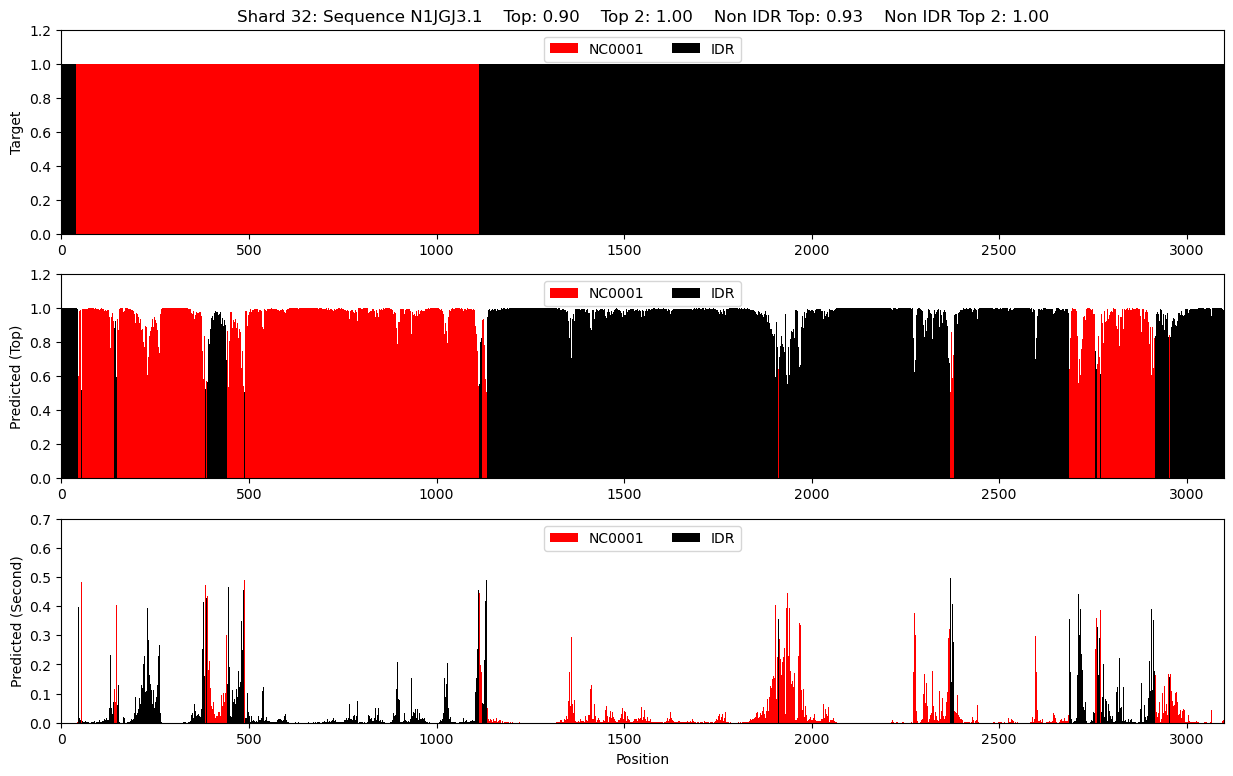

In [77]:
shard = np.random.randint(1,51)
# shard = 32
with open(f'../data/results/try_lstm_part2/predictions_esm2_t33_650M_UR50D/shard_{shard}.pkl', 'rb') as g:
        results = pickle.load(g)

with open(f'../data/maps.pkl', 'rb') as g:
        maps = pickle.load(g)
clan_map = list(maps['clan_idx'].keys())

keys = list(results.keys())
seq = keys[np.random.randint(0,len(keys))]
# seq = 'N1JGJ3.1'

print(f'Shard {shard}: Sequence {seq}')
vz.viewSingleClan(shard, seq, results, clan_map)

In [ ]:
Shard 12: Sequence B0W570.1

In [ ]:
import sys
# sys.path.insert(0, '../py_scripts')
import visualizations as vz
import pickle

with open(f'../data/maps.pkl', 'rb') as g:
        maps = pickle.load(g)
fam_map = list(maps['fam_idx'].keys())

In [ ]:
with open(f'../data/results/simple_resume_no_L1/single_pred.pkl', 'rb') as g:
        results = pickle.load(g)

seq = results['label']
shard = results['shard']

print(f'Shard {shard}: Sequence {seq}')
vz.viewSingleFam(shard, seq, results, fam_map)

In [ ]:
import hmmscan_utils as hu

scan_dict = hu.parse_hmmscan_results('../data/split_34_test_ids_full.fasta_scan.txt')

In [ ]:
scan_dict['I0AHU5.1']

In [ ]:
import torch

In [ ]:
test = torch.randn((4,4))

In [ ]:
test

In [ ]:
test[[1,3],[0,2]]

In [ ]:

# Specify the indices for dimension 0 and dimension 1
indices_dim0 = torch.tensor([1, 3])
indices_dim1 = torch.tensor([0, 2])

# Use advanced indexing to get the desired elements
result = test[indices_dim0.reshape(-1, 1), indices_dim1]

print(result)

In [ ]:
# Specify the indices for dimension 0 and dimension 1
indices_dim0 = torch.tensor([1, 3])
indices_dim1 = [0,2]

# Use advanced indexing to get the desired elements
test[indices_dim0[:,None], indices_dim1] = 10

print(test)

In [ ]:
test2 = torch.tensor([1,2,3,4,1,2,1,2,1])

In [ ]:
mask = (test2 == 1)

In [ ]:
mask

In [ ]:
test2 = torch.tensor([1,2,3,4,5,2])

In [ ]:
test3 = torch.where(test2==2)

In [2]:
import sys
import numpy as np
sys.path.insert(0, '../library')
# sys.path.insert(0, '../py_scripts')
import hmmscan_utils as hu
import classifiers as cf
import ml_utils as mu
import visualizations as vz
import torch
import pickle
from pathlib import Path
print("imported")
with open(f'../data/maps.pkl', 'rb') as g:
        maps = pickle.load(g)
fam_map = list(maps['fam_idx'].keys())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

length_limit = 4096 # Covers 99.75% sequences
model_name =  'esm2_t33_650M_UR50D' #'esm2_t36_3B_UR50D'
num_shards = 50 ###### Replace with appropriate number ###################################
data_utils = mu.DataUtils('../data', num_shards, model_name, length_limit, 'test', device,"_OLD")
print("ESM2 loaded")
classifier = cf.FamModelSimple(data_utils.embedding_dim, data_utils.maps, device).to(device)
classifier_path = Path('../data/results/no_l1_part3/epoch_9.pth')
classifier.load_state_dict(torch.load(classifier_path))

clan_classifier = cf.ClanLSTM(data_utils.embedding_dim,data_utils.clan_count).to(device)
clan_classifier_path = Path('../data/results/Clan_finetune/epoch_3.pth')
clan_classifier.load_state_dict(torch.load(clan_classifier_path))
print("Classifier loaded")
classifier.eval()
clan_classifier.eval()

imported
ESM2 loaded
Classifier loaded


ClanLSTM(
  (lstm): LSTM(1280, 1280, bidirectional=True)
  (linear_stack): Sequential(
    (0): Linear(in_features=2560, out_features=5120, bias=True)
    (1): ReLU()
    (2): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=5120, out_features=5120, bias=True)
    (4): ReLU()
    (5): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=5120, out_features=657, bias=True)
  )
)

Shard 10: Sequence R5YHW5.1


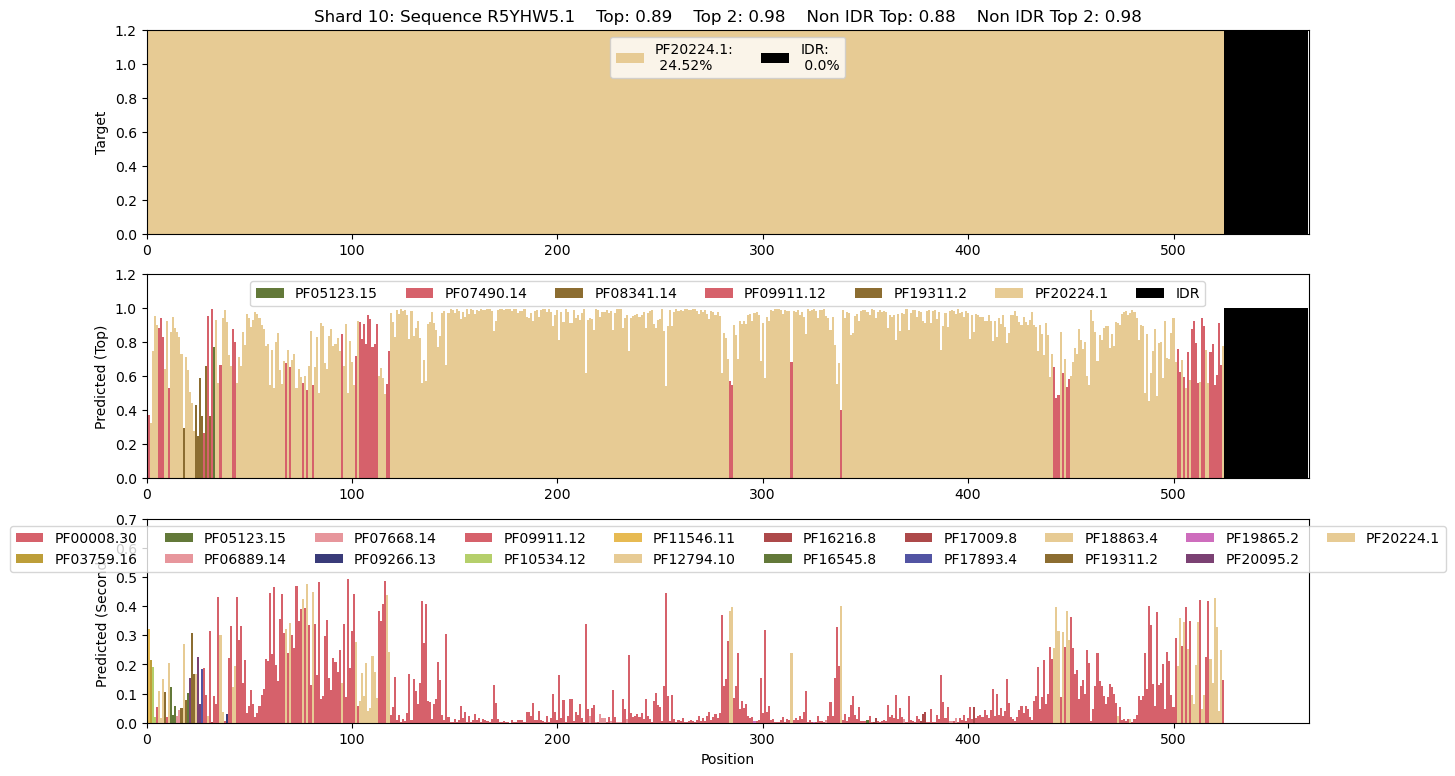

In [10]:
with torch.inference_mode():

    shard = np.random.randint(1,51)
    shard = 10

    hmm_dict = data_utils.parse_shard(shard)
    keys = list(hmm_dict.keys())
    key_idx = np.random.randint(0,len(keys))
    seq_id = keys[key_idx]
    seq_id = 'R5YHW5.1'

    dataset = data_utils.get_dataset(shard)
    dataset = data_utils.filter_batches(dataset, [seq_id])
    data_loader = data_utils.get_dataloader(dataset)

    label, seq, token = next(iter(data_loader))
    token = token.to(device)
    embedding = data_utils.get_embedding(token)
    fam_vector, clan_vector = hu.generate_domain_position_list2(hmm_dict, seq_id, data_utils.maps)
                    
    stop_index = min(len(seq[0]), data_utils.length_limit)
    fam_vector = torch.tensor(fam_vector[:stop_index,:]).to(device) # clip the clan_vector to the truncated sequence length
    clan_vector = torch.tensor(clan_vector[:stop_index,:]).to(device)

    weighted_preds, _ = classifier(embedding["representations"][data_utils.last_layer][0,1:stop_index+1,:], clan_vector)
    clan_fam_matrix = maps['clan_family_matrix'].to(device)
    clan_fam_weights = torch.matmul(clan_vector,clan_fam_matrix)

    for i in range(clan_fam_weights.shape[0]): #shape is cxf
        indices = torch.nonzero(clan_fam_weights[i]).squeeze() #indices for the softmax
        weighted_preds[i,indices] = torch.softmax(weighted_preds[i,indices],dim=0)
 
    results = {}
    results[seq_id] = {}
    top_two_vals, top_two_indices = torch.topk(weighted_preds, k=2, dim=1)

    
    results[seq_id]['fam_vals'] = top_two_vals.cpu().numpy()
    results[seq_id]['fam_idx'] = top_two_indices.cpu().numpy()
    results[seq_id]['fam_true'] = torch.argmax(fam_vector, dim=1).cpu().numpy()
    results[seq_id]['fam_true_vals'] = fam_vector.max(dim=1)[1].cpu().numpy()
    results['label'] = seq_id
    results['shard'] = shard
    print(f'Shard {shard}: Sequence {seq_id}')
    # vz.viewSingleClan(shard,seq_id,results,list(maps['clan_idx'].keys()),"old_test_pids_CLAN.pkl")
    vz.viewSingleFam(shard, seq_id, results, list(maps['fam_idx'].keys()), "old_test_pids.pkl")

Shard 10: Sequence R5YHW5.1


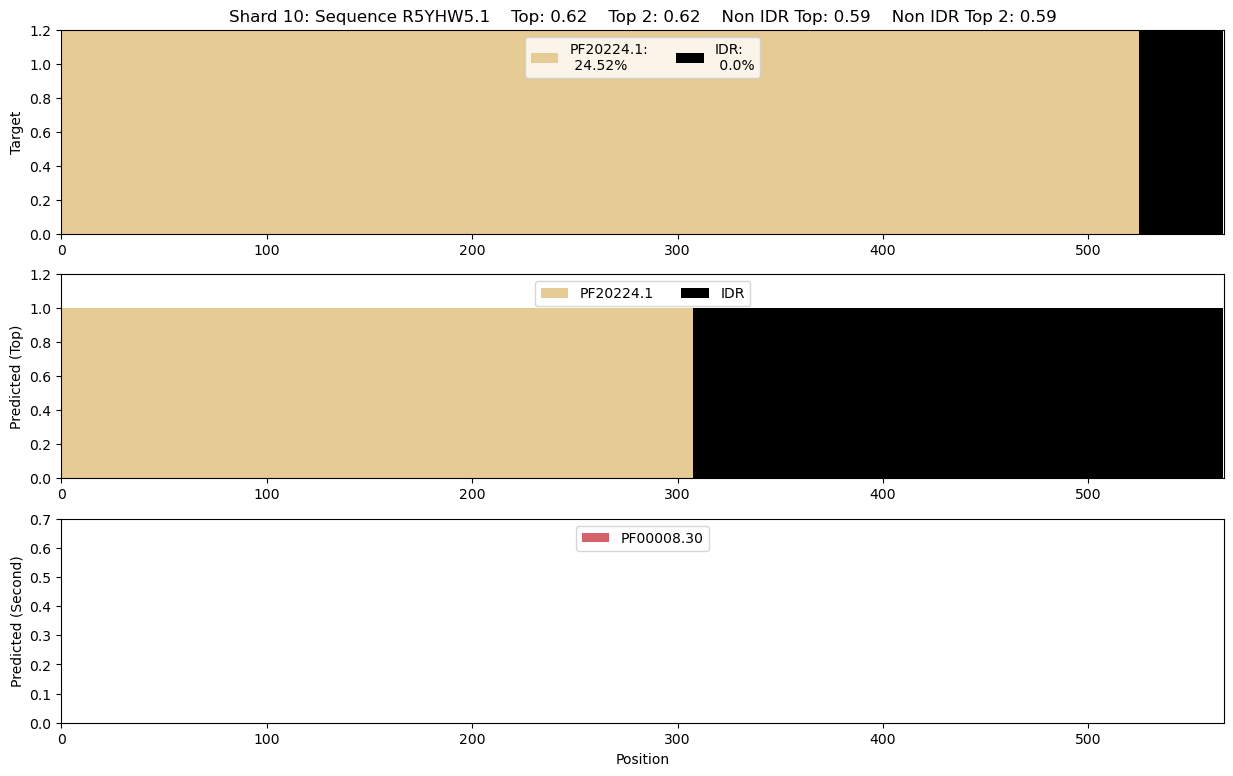

In [9]:
import sys
import numpy as np
sys.path.insert(0, '../library')
# sys.path.insert(0, '../py_scripts')
import hmmscan_utils as hu
import classifiers as cf
import ml_utils as mu
import visualizations as vz
import torch
import pickle
from pathlib import Path
with torch.inference_mode():
    with open(f'../data/maps.pkl', 'rb') as g:
        maps = pickle.load(g)
    shard = np.random.randint(1,51)
    # shard = 34

    hmm_dict = hu.parse_hmmscan_results(f"../data/test_scan_OLD/split_{shard}_test_ids_full.fasta_scan.txt")
    pred_dict = hu.parse_hmmscan_results(f"../data/test_hmmer_preds/split_{shard}_test_ids_full.fasta_scan.txt")
    keys = list(hmm_dict.keys())
    key_idx = np.random.randint(0,len(keys))
    seq_id = keys[key_idx]
    # seq_id = 'I0AHU5.1'


    ######
    results = {}
    results[seq_id] = {}

    fam_vector, _ = hu.generate_domain_position_list2(hmm_dict, seq_id, maps)
    fam_vector = torch.tensor(fam_vector)
    pred_vector, _ = hu.generate_domain_position_list2(pred_dict, seq_id, maps) # Account for no hits
    pred_vector = torch.tensor(pred_vector)
    stop_index_fam = min(hmm_dict[seq_id]['length'], 4096) # Hard coded limit currently
    stop_index_pred = min(pred_dict[seq_id]['length'], 4096)


    #######

    top_two_vals, top_two_indices = torch.topk(pred_vector, k=2, dim=1)


    results[seq_id]['fam_vals'] = top_two_vals.cpu().numpy()
    results[seq_id]['fam_idx'] = top_two_indices.cpu().numpy()
    results[seq_id]['fam_true'] = torch.argmax(fam_vector, dim=1).cpu().numpy()
    results[seq_id]['fam_true_vals'] = fam_vector.max(dim=1)[1].cpu().numpy()
    results['seq_id'] = seq_id
    results['shard'] = shard
    print(f'Shard {shard}: Sequence {seq_id}')
    # vz.viewSingleClan(shard,seq_id,results,list(maps['clan_idx'].keys()),"old_test_pids_CLAN.pkl")
    vz.viewSingleFam(shard, seq_id, results, list(maps['fam_idx'].keys()), "old_test_pids.pkl")

In [27]:
import torch.nn.functional as F

Shard 5: Sequence T2KHU9.1


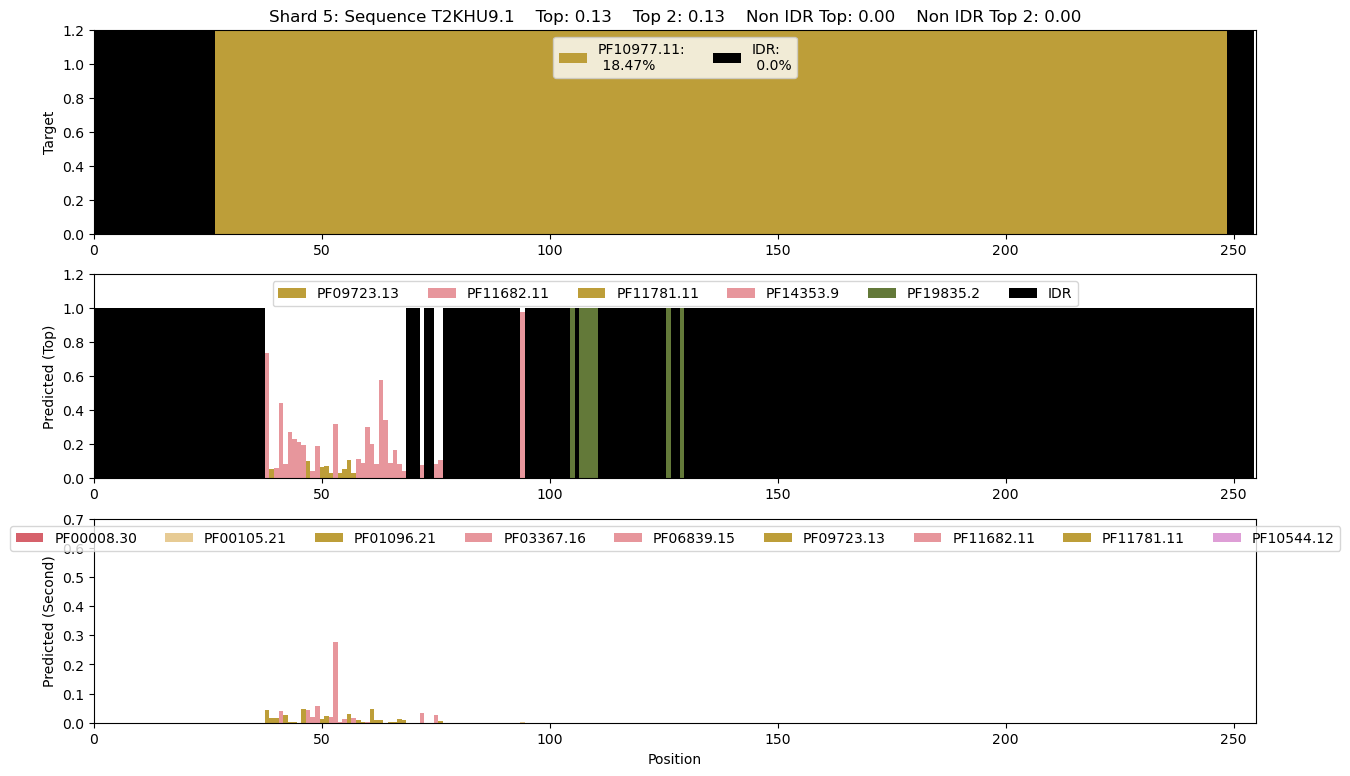

In [35]:
# ONE HOT CLAN
with torch.inference_mode():

    shard = np.random.randint(1,51)
    shard = 5

    hmm_dict = data_utils.parse_shard(shard)
    keys = list(hmm_dict.keys())
    key_idx = np.random.randint(0,len(keys))
    seq_id = keys[key_idx]
    seq_id = 'T2KHU9.1'

    dataset = data_utils.get_dataset(shard)
    dataset = data_utils.filter_batches(dataset, [seq_id])
    data_loader = data_utils.get_dataloader(dataset)

    label, seq, token = next(iter(data_loader))
    token = token.to(device)
    embedding = data_utils.get_embedding(token)
    fam_vector, clan_vector = hu.generate_domain_position_list2(hmm_dict, seq_id, data_utils.maps)
                    
    stop_index = min(len(seq[0]), data_utils.length_limit)
    fam_vector = torch.tensor(fam_vector[:stop_index,:]).to(device) # clip the clan_vector to the truncated sequence length
    clan_vector = torch.tensor(clan_vector[:stop_index,:]).to(device)
    
    #### Get clan preds
    clan_preds = clan_classifier(embedding["representations"][data_utils.last_layer][0,1:stop_index+1,:])
    clan_preds = F.softmax(clan_preds, dim=1)
    # Find the indices of the max values along dimension 1
    max_indices = torch.argmax(clan_preds, dim=1)
    # Create a tensor of zeros with the same shape as clan_preds
    clan_preds_one_hot = torch.zeros_like(clan_preds)
    # Replace the max indices with 1
    clan_preds_one_hot.scatter_(1, max_indices.unsqueeze(1), 1)
    clan_preds = clan_preds_one_hot
    

    weighted_preds, _ = classifier(embedding["representations"][data_utils.last_layer][0,1:stop_index+1,:], clan_preds)
    weighted_preds = torch.softmax(weighted_preds,dim=1)
#     clan_fam_matrix = maps['clan_family_matrix'].to(device)
#     clan_fam_weights = torch.matmul(clan_vector,clan_fam_matrix)

#     for i in range(clan_fam_weights.shape[0]): #shape is Lxf
#         indices = torch.nonzero(clan_fam_weights[i]).squeeze() #indices for the softmax
#         weighted_preds[i,indices] = torch.softmax(weighted_preds[i,indices],dim=0)
 
    results = {}
    results[seq_id] = {}
    top_two_vals, top_two_indices = torch.topk(weighted_preds, k=2, dim=1)

    
    results[seq_id]['fam_vals'] = top_two_vals.cpu().numpy()
    results[seq_id]['fam_idx'] = top_two_indices.cpu().numpy()
    results[seq_id]['fam_true'] = torch.argmax(fam_vector, dim=1).cpu().numpy()
    results[seq_id]['fam_true_vals'] = fam_vector.max(dim=1)[1].cpu().numpy()
    results['label'] = seq_id
    results['shard'] = shard
    print(f'Shard {shard}: Sequence {seq_id}')
    # vz.viewSingleClan(shard,seq_id,results,list(maps['clan_idx'].keys()),"old_test_pids_CLAN.pkl")
    vz.viewSingleFam(shard, seq_id, results, list(maps['fam_idx'].keys()), "old_test_pids.pkl")

In [ ]:
hmm_dict['A6GJW3.1']

In [ ]:
print(weighted_preds.shape,weighted_preds.sum(dim=1))

In [ ]:
print(raw_preds.shape,raw_preds.sum(dim=1))

In [ ]:
clan_fam_matrix = maps['clan_family_matrix'].to(device)
clan_fam_weights = torch.matmul(clan_vector,clan_fam_matrix)

In [ ]:
# For each row, print the indices where there are 1s
weighted_preds_clone = weighted_preds.clone()
for i in range(clan_fam_weights.shape[0]): #shape is Lxf
    indices = torch.nonzero(clan_fam_weights[i]).squeeze() #indices for the softmax
    weighted_preds_clone[i,indices] = torch.softmax(weighted_preds[i,indices],dim=0)
    # if i==88:
        # print(f"Row {i}: {indices.tolist()}")

In [ ]:
weighted_preds[1,2892]

In [ ]:
clan_fam_weights.sum(dim=1)

In [ ]:
weighted_preds.sum(dim=1)

In [ ]:
weighted_preds = torch.softmax(weighted_preds,dim=1)

In [ ]:
weighted_preds[0,:]

In [ ]:
weighted_preds

In [ ]:
maps['clan_idx'][maps['fam_clan'][maps['idx_fam'][2892]]]

In [ ]:
viz = top5_argmaxes_with_values(weighted_preds, maps['idx_fam'],2)

In [ ]:
raw_preds_sm = torch.softmax(raw_preds,dim=1)

In [ ]:
results = {}
seq_id = "P14528.1"
shard = 1
results[seq_id] = {}

top_two_vals, top_two_indices = torch.topk(weighted_preds_clone, k=2, dim=1)

results[seq_id]['fam_vals'] = top_two_vals.cpu().numpy()
results[seq_id]['fam_idx'] = top_two_indices.cpu().numpy()
results[seq_id]['fam_true'] = torch.argmax(fam_vector, dim=1).cpu().numpy()
results['label'] = seq_id
results['shard'] = shard

In [ ]:
import sys
sys.path.insert(0,"../py_scripts")

import visualizations as vz
print(f'Shard {shard}: Sequence {seq_id}')
vz.viewSingleFam(shard, seq_id, results, list(maps['fam_idx'].keys()))

In [ ]:
results = {}
seq_id = "P14528.1"
shard = 1
results[seq_id] = {}

top_two_vals, top_two_indices = torch.topk(raw_preds_sm, k=2, dim=1)

results[seq_id]['fam_vals'] = top_two_vals.cpu().numpy()
results[seq_id]['fam_idx'] = top_two_indices.cpu().numpy()
results[seq_id]['fam_true'] = torch.argmax(fam_vector, dim=1).cpu().numpy()
results['label'] = seq_id
results['shard'] = shard
print(f'Shard {shard}: Sequence {seq_id}')
vz.viewSingleFam(shard, seq_id, results, list(maps['fam_idx'].keys()))

In [3]:
import pickle
import polars as pl

with open('../data/results/no_l1_part3/predictions_esm2_t33_650M_UR50D/fam_results_epoch9.pkl', 'rb') as f:
    tmp = pickle.load(f)

# Easier to convert this into dataframe for easier processing - turn this into utility!!!!
seq = []
top = []
top2 = []
fam = []
fam2 = []
adj = []
non_idr = []
non_idr2 = []

for entry in tmp.keys():
    seq.append(entry)
    top.append(tmp[entry]['top'])
    top2.append(tmp[entry]['top2'])
    fam.append(tmp[entry]['fam_top'])
    fam2.append(tmp[entry]['fam_top2'])
    adj.append(tmp[entry]['adjusted_acc'])
    non_idr.append(tmp[entry]['non_idr_top'])
    non_idr2.append(tmp[entry]['non_idr_top2'])

df = pl.from_dict({'Sequence': seq, 'Top': top, 'Top2': top2, 'Fam_top': fam, 'Fam_top2': fam2, 'Adjusted': adj, 'Non IDR': non_idr, 'Non IDR 2': non_idr2})
df = df.filter(pl.col('Non IDR').is_not_nan())

In [2]:
df.mean()

Sequence,Top,Top2,Fam_top,Fam_top2,Adjusted,Non IDR,Non IDR 2
str,f64,f64,f64,f64,f64,f64,f64
null,0.771658,0.823409,0.809098,0.853712,0.801356,NaN,NaN


(array([  6292.,   8800.,   6491.,   5961.,   5843.,   6155.,   6719.,
          8275.,   9744., 102296.]),
 array([0.        , 0.09999998, 0.19999995, 0.29999993, 0.3999999 ,
        0.49999988, 0.59999985, 0.69999983, 0.7999998 , 0.89999978,
        0.99999976]),
 <BarContainer object of 10 artists>)

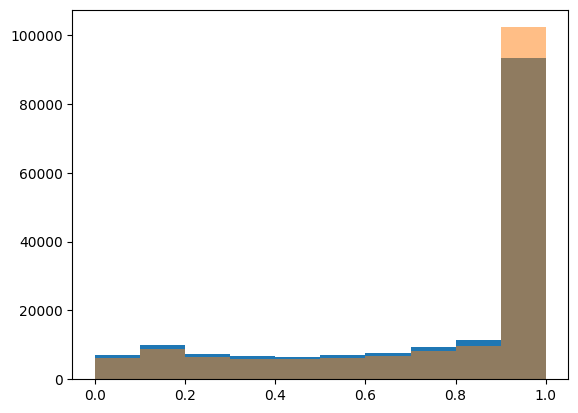

In [33]:
import matplotlib.pyplot as plt
plt.hist(df.select('Top'))

plt.hist(df.select('Adjusted'), alpha=0.5)

In [24]:
(df.select('Top2') > 0.999).sum()

Top2
u32
78080


Saving maps of which sequences are found in which shard.
Also storing list of sequences in each pid based split

In [1]:
from pathlib import Path
from Bio import SeqIO

all_shard_path = Path('../data/test_fasta_OLD/')
num_shards = 50

seq_shard_map = {}

for i in range(1,num_shards+1):
    for record in SeqIO.parse(all_shard_path / f'split_{i}_test_ids_full.fasta', 'fasta'):
        seq_shard_map[record.id] = i

In [35]:
pid_splits = [20, 40, 60, 80, 100]
num_shards = 50

split_seqs = {}

for pid in pid_splits:
    folder = Path(f'../data/test_fasta_{pid}')
    split_seqs[pid] = []

    for i in range(1, num_shards+1):
        for record in SeqIO.parse(folder / f'split_{i}_test_ids_full.fasta', 'fasta'):
            split_seqs[pid].append(record.id)

In [2]:
import pickle
with open(f'../data/shard_seqs2.pkl', 'wb') as f: # This code was recycled to save both the above maps
    pickle.dump(seq_shard_map, f)

In [12]:
df_20 = df.filter(pl.col('Sequence').is_in(split_seqs[20]))
df_40 = df.filter(pl.col('Sequence').is_in(split_seqs[40]))
df_60 = df.filter(pl.col('Sequence').is_in(split_seqs[60]))
df_80 = df.filter(pl.col('Sequence').is_in(split_seqs[80]))
df_100 = df.filter(pl.col('Sequence').is_in(split_seqs[100]))

print('20', df_20.mean())
print('40', df_40.mean())
print('60', df_60.mean())
print('80', df_80.mean())
print('100', df_100.mean())

20 shape: (1, 8)
┌──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬───────────┐
│ Sequence ┆ Top      ┆ Top2     ┆ Fam_top  ┆ Fam_top2 ┆ Adjusted ┆ Non IDR  ┆ Non IDR 2 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ str      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ null     ┆ 0.548265 ┆ 0.610809 ┆ 0.666491 ┆ 0.711429 ┆ 0.58561  ┆ 0.342928 ┆ 0.432231  │
└──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴───────────┘
40 shape: (1, 8)
┌──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬───────────┐
│ Sequence ┆ Top      ┆ Top2     ┆ Fam_top  ┆ Fam_top2 ┆ Adjusted ┆ Non IDR  ┆ Non IDR 2 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ str      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆

In [32]:
import pickle
import polars as pl

with open('../data/results/clan_20epoch_p2/predictions_esm2_t33_650M_UR50D/clan_results.pkl', 'rb') as f:
    tmp = pickle.load(f)

# Easier to convert this into dataframe for easier processing - turn this into utility!!!!
seq = []
top = []
top2 = []
clan = []
clan2 = []
adj = []
non_idr = []
non_idr2 = []

for entry in tmp.keys():
    seq.append(entry)
    top.append(tmp[entry]['top'])
    top2.append(tmp[entry]['top2'])
    clan.append(tmp[entry]['clan_top'])
    clan2.append(tmp[entry]['clan_top2'])
    adj.append(tmp[entry]['adjusted_acc'])
    non_idr.append(tmp[entry]['non_idr_top'])
    non_idr2.append(tmp[entry]['non_idr_top2'])

df_clan = pl.from_dict({'Sequence': seq, 'Top': top, 'Top2': top2, 'Clan_top': clan, 'Clan_top2': clan2, 'Adjusted': adj, 'Non IDR': non_idr, 'Non IDR 2': non_idr2})
df_clan = df_clan.filter(pl.col('Non IDR').is_not_nan())


In [3]:
with open(f'../data/split_seqs.pkl', 'rb') as f: # This code was recycled to save both the above maps
    split_seqs = pickle.load(f)

In [6]:
df_clan_20 = df_clan.filter(pl.col('Sequence').is_in(split_seqs[20]))
df_clan_40 = df_clan.filter(pl.col('Sequence').is_in(split_seqs[40]))
df_clan_60 = df_clan.filter(pl.col('Sequence').is_in(split_seqs[60]))
df_clan_80 = df_clan.filter(pl.col('Sequence').is_in(split_seqs[80]))
df_clan_100 = df_clan.filter(pl.col('Sequence').is_in(split_seqs[100]))

print('20', df_clan_20.mean())
print('40', df_clan_40.mean())
print('60', df_clan_60.mean())
print('80', df_clan_80.mean())
print('100', df_clan_100.mean())

20 shape: (1, 8)
┌──────────┬──────────┬──────────┬──────────┬───────────┬──────────┬──────────┬───────────┐
│ Sequence ┆ Top      ┆ Top2     ┆ Clan_top ┆ Clan_top2 ┆ Adjusted ┆ Non IDR  ┆ Non IDR 2 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---      ┆ ---       │
│ str      ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64      ┆ f64      ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══════════╪══════════╪══════════╪═══════════╡
│ null     ┆ 0.793466 ┆ 0.928931 ┆ 0.790949 ┆ 0.941579  ┆ 0.910369 ┆ 0.768591 ┆ 0.893035  │
└──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴──────────┴───────────┘
40 shape: (1, 8)
┌──────────┬──────────┬──────────┬──────────┬───────────┬──────────┬──────────┬───────────┐
│ Sequence ┆ Top      ┆ Top2     ┆ Clan_top ┆ Clan_top2 ┆ Adjusted ┆ Non IDR  ┆ Non IDR 2 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---      ┆ ---       │
│ str      ┆ f64      ┆ f64      ┆ f64      ┆ 

In [2]:
import pickle
import polars as pl

with open('../data/results/hmmer_preds/fam_results.pkl', 'rb') as f:
    tmp = pickle.load(f)

# Easier to convert this into dataframe for easier processing - turn this into utility!!!!
seq = []
top = []
fam = []
adj = []
non_idr = []

for entry in tmp.keys():
    seq.append(entry)
    top.append(tmp[entry]['top'])
    fam.append(tmp[entry]['fam_top'])
    adj.append(tmp[entry]['adjusted_acc'])
    non_idr.append(tmp[entry]['non_idr_top'])

df_hmmer = pl.from_dict({'Sequence': seq, 'Top': top, 'Fam_top': fam, 'Adjusted': adj, 'Non IDR': non_idr})
df_hmmer = df_hmmer.filter(pl.col('Non IDR').is_not_nan())

In [3]:
with open(f'../data/split_seqs.pkl', 'rb') as f: # This code was recycled to save both the above maps
    split_seqs = pickle.load(f)

In [16]:
df_hmmer_20 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[20]))
df_hmmer_40 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[40]))
df_hmmer_60 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[60]))
df_hmmer_80 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[80]))
df_hmmer_100 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[100]))

df_f20 = df_20.select(['Sequence', 'Top', 'Fam_top', 'Adjusted', 'Non IDR'])
df_f40 = df_40.select(['Sequence', 'Top', 'Fam_top', 'Adjusted', 'Non IDR'])
df_f60 = df_60.select(['Sequence', 'Top', 'Fam_top', 'Adjusted', 'Non IDR'])
df_f80 = df_80.select(['Sequence', 'Top', 'Fam_top', 'Adjusted', 'Non IDR'])
df_f100 = df_100.select(['Sequence', 'Top', 'Fam_top', 'Adjusted', 'Non IDR'])

print('20', df_hmmer_20.mean(), df_f20.mean())
print('40', df_hmmer_40.mean(), df_f40.mean())
print('60', df_hmmer_60.mean(), df_f60.mean())
print('80', df_hmmer_80.mean(), df_f80.mean())
print('100', df_hmmer_100.mean(), df_f100.mean()) 

20 shape: (1, 5)
┌──────────┬─────────┬──────────┬──────────┬──────────┐
│ Sequence ┆ Top     ┆ Fam_top  ┆ Adjusted ┆ Non IDR  │
│ ---      ┆ ---     ┆ ---      ┆ ---      ┆ ---      │
│ str      ┆ f64     ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪═════════╪══════════╪══════════╪══════════╡
│ null     ┆ 0.47941 ┆ 0.607502 ┆ 0.484855 ┆ 0.232089 │
└──────────┴─────────┴──────────┴──────────┴──────────┘ shape: (1, 5)
┌──────────┬──────────┬──────────┬──────────┬──────────┐
│ Sequence ┆ Top      ┆ Fam_top  ┆ Adjusted ┆ Non IDR  │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ null     ┆ 0.548265 ┆ 0.666491 ┆ 0.58561  ┆ 0.342928 │
└──────────┴──────────┴──────────┴──────────┴──────────┘
40 shape: (1, 5)
┌──────────┬──────────┬──────────┬──────────┬──────────┐
│ Sequence ┆ Top      ┆ Fam_top  ┆ Adjusted ┆ Non IDR  │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ -

Text(0.5, 1.0, 'Accuracy for family identification')

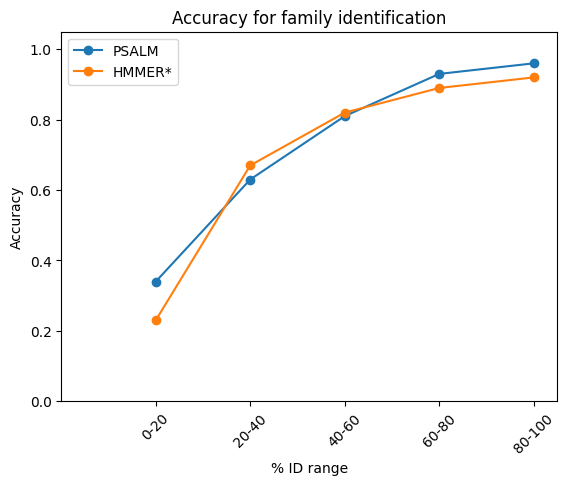

In [23]:
import matplotlib.pyplot as plt

fam_hmmer = [0.23, 0.67, 0.82, 0.89, 0.92]
fam_psalm = [0.34, 0.63, 0.81, 0.93, 0.96]
pids = [0.2, 0.4, 0.6, 0.8, 1.0]

plt.figure()

plt.plot(pids, fam_psalm, label='PSALM', marker='o')
plt.plot(pids, fam_hmmer, label='HMMER*', marker='o')

plt.xlabel('% ID range')
plt.ylabel('Accuracy')
plt.xlim(0,1.05)
plt.xticks(pids, ['0-20', '20-40', '40-60', '60-80', '80-100'], rotation=45)
plt.ylim(0,1.05)
plt.legend()
plt.title('Accuracy for family identification')

In [9]:
import pickle
import polars as pl

with open('../data/results/hmmer_preds/clan_results.pkl', 'rb') as f:
    tmp = pickle.load(f)

# Easier to convert this into dataframe for easier processing - turn this into utility!!!!
seq = []
top = []
fam = []
adj = []
non_idr = []

for entry in tmp.keys():
    seq.append(entry)
    top.append(tmp[entry]['top'])
    fam.append(tmp[entry]['clan_top'])
    adj.append(tmp[entry]['adjusted_acc'])
    non_idr.append(tmp[entry]['non_idr_top'])

df_hmmer_clan = pl.from_dict({'Sequence': seq, 'Top': top, 'Clan_top': fam, 'Adjusted': adj, 'Non IDR': non_idr})
df_hmmer_clan = df_hmmer_clan.filter(pl.col('Non IDR').is_not_nan())

In [34]:
# df_hmmer_clan_20 = df_hmmer_clan.filter(pl.col('Sequence').is_in(split_seqs[20]))
# df_hmmer_clan_40 = df_hmmer_clan.filter(pl.col('Sequence').is_in(split_seqs[40]))
# df_hmmer_clan_60 = df_hmmer_clan.filter(pl.col('Sequence').is_in(split_seqs[60]))
# df_hmmer_clan_80 = df_hmmer_clan.filter(pl.col('Sequence').is_in(split_seqs[80]))
# df_hmmer_clan_100 = df_hmmer_clan.filter(pl.col('Sequence').is_in(split_seqs[100]))

# df_hmmer_clan_20 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(20)))
# df_hmmer_clan_40 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(40)))
# df_hmmer_clan_60 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(60)))
# df_hmmer_clan_80 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(80)))
# df_hmmer_clan_100 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(100)))

# df_clan_f20 = df_clan.filter(pl.col('Sequence').is_in(not_nc(20)))
# df_clan_f40 = df_clan.filter(pl.col('Sequence').is_in(not_nc(40)))
# df_clan_f60 = df_clan.filter(pl.col('Sequence').is_in(not_nc(60)))
# df_clan_f80 = df_clan.filter(pl.col('Sequence').is_in(not_nc(80)))
# df_clan_f100 = df_clan.filter(pl.col('Sequence').is_in(not_nc(100)))

df_hmmer_clan_20 = df_hmmer.filter(pl.col('Sequence').is_in(nc(20)))
df_hmmer_clan_40 = df_hmmer.filter(pl.col('Sequence').is_in(nc(40)))
df_hmmer_clan_60 = df_hmmer.filter(pl.col('Sequence').is_in(nc(60)))
df_hmmer_clan_80 = df_hmmer.filter(pl.col('Sequence').is_in(nc(80)))
df_hmmer_clan_100 = df_hmmer.filter(pl.col('Sequence').is_in(nc(100)))

df_clan_f20 = df_clan.filter(pl.col('Sequence').is_in(nc(20)))
df_clan_f40 = df_clan.filter(pl.col('Sequence').is_in(nc(40)))
df_clan_f60 = df_clan.filter(pl.col('Sequence').is_in(nc(60)))
df_clan_f80 = df_clan.filter(pl.col('Sequence').is_in(nc(80)))
df_clan_f100 = df_clan.filter(pl.col('Sequence').is_in(nc(100)))

# df_clan_f20 = df_clan_20.select(['Sequence', 'Top', 'Clan_top', 'Adjusted', 'Non IDR'])
# df_clan_f40 = df_clan_40.select(['Sequence', 'Top', 'Clan_top', 'Adjusted', 'Non IDR'])
# df_clan_f60 = df_clan_60.select(['Sequence', 'Top', 'Clan_top', 'Adjusted', 'Non IDR'])
# df_clan_f80 = df_clan_80.select(['Sequence', 'Top', 'Clan_top', 'Adjusted', 'Non IDR'])
# df_clan_f100 = df_clan_100.select(['Sequence', 'Top', 'Clan_top', 'Adjusted', 'Non IDR'])

print('20', df_hmmer_clan_20.mean(), df_clan_f20.mean())
print('40', df_hmmer_clan_40.mean(), df_clan_f40.mean())
print('60', df_hmmer_clan_60.mean(), df_clan_f60.mean())
print('80', df_hmmer_clan_80.mean(), df_clan_f80.mean())
print('100', df_hmmer_clan_100.mean(), df_clan_f100.mean()) 

20 shape: (1, 5)
┌──────────┬──────────┬─────────┬──────────┬─────────┐
│ Sequence ┆ Top      ┆ Fam_top ┆ Adjusted ┆ Non IDR │
│ ---      ┆ ---      ┆ ---     ┆ ---      ┆ ---     │
│ str      ┆ f64      ┆ f64     ┆ f64      ┆ f64     │
╞══════════╪══════════╪═════════╪══════════╪═════════╡
│ null     ┆ 0.472205 ┆ 0.60187 ┆ 0.476907 ┆ 0.21551 │
└──────────┴──────────┴─────────┴──────────┴─────────┘ shape: (1, 8)
┌──────────┬──────────┬──────────┬──────────┬───────────┬──────────┬──────────┬───────────┐
│ Sequence ┆ Top      ┆ Top2     ┆ Clan_top ┆ Clan_top2 ┆ Adjusted ┆ Non IDR  ┆ Non IDR 2 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---      ┆ ---       │
│ str      ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64      ┆ f64      ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══════════╪══════════╪══════════╪═══════════╡
│ null     ┆ 0.814918 ┆ 0.957207 ┆ 0.805903 ┆ 0.964122  ┆ 0.950065 ┆ 0.801159 ┆ 0.933694  │
└──────────┴──────────┴─────────

Text(0.5, 1.0, 'Accuracy for clan identification')

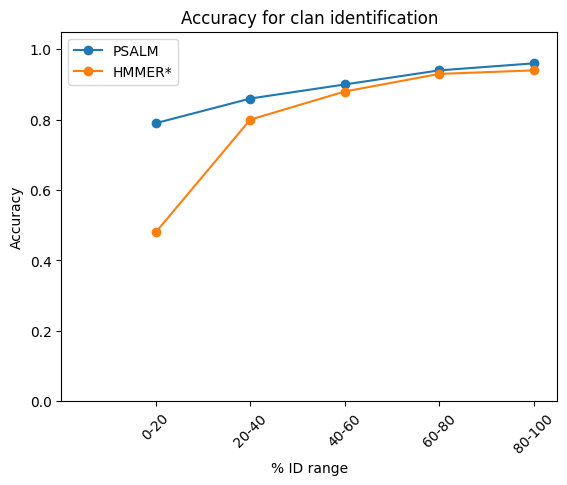

In [11]:
import matplotlib.pyplot as plt

clan_hmmer = [0.48, 0.80, 0.88, 0.93, 0.94]
clan_psalm = [0.79, 0.86, 0.90, 0.94, 0.96]
pids = [0.2, 0.4, 0.6, 0.8, 1.0]

plt.figure()

plt.plot(pids, clan_psalm, label='PSALM', marker='o')
plt.plot(pids, clan_hmmer, label='HMMER*', marker='o')

plt.xlabel('% ID range')
plt.ylabel('Accuracy')
plt.xlim(0,1.05)
plt.xticks(pids, ['0-20', '20-40', '40-60', '60-80', '80-100'], rotation=45)
plt.ylim(0,1.05)
plt.legend()
plt.title('Accuracy for clan identification')

In [4]:
import pickle
import polars as pl

with open('../data/results/no_l1_part3/predictions_esm2_t33_650M_UR50D/joint_results.pkl', 'rb') as f:
    tmp = pickle.load(f)
# with open('../data/results/clan_fam_onehots/joint_results_onehot.pkl', 'rb') as f:
#     tmp = pickle.load(f)

# Easier to convert this into dataframe for easier processing - turn this into utility!!!!
seq = []
top = []
top2 = []
fam = []
fam2 = []
adj = []
non_idr = []

for entry in tmp.keys():
    seq.append(entry)
    top.append(tmp[entry]['top'])
    top2.append(tmp[entry]['top2'])
    fam.append(tmp[entry]['fam_top'])
    fam2.append(tmp[entry]['fam_top2'])
    adj.append(tmp[entry]['adjusted_acc'])
    non_idr.append(tmp[entry]['non_idr_top'])

df_joint = pl.from_dict({'Sequence': seq, 'Top': top, 'Top2': top2, 'Fam_top': fam, 'Adjusted': adj, 'Non IDR': non_idr})
df_joint = df_joint.filter(pl.col('Non IDR').is_not_nan())

In [5]:
df_hmmer_20 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[20]))
df_hmmer_40 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[40]))
df_hmmer_60 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[60]))
df_hmmer_80 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[80]))
df_hmmer_100 = df_hmmer.filter(pl.col('Sequence').is_in(split_seqs[100]))

df_j20 = df_joint.filter(pl.col('Sequence').is_in(split_seqs[20]))
df_j40 = df_joint.filter(pl.col('Sequence').is_in(split_seqs[40]))
df_j60 = df_joint.filter(pl.col('Sequence').is_in(split_seqs[60]))
df_j80 = df_joint.filter(pl.col('Sequence').is_in(split_seqs[80]))
df_j100 = df_joint.filter(pl.col('Sequence').is_in(split_seqs[100]))

# df_hmmer_20 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(20)))
# df_hmmer_40 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(40)))
# df_hmmer_60 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(60)))
# df_hmmer_80 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(80)))
# df_hmmer_100 = df_hmmer.filter(pl.col('Sequence').is_in(not_nc(100)))

# df_j20 = df_joint.filter(pl.col('Sequence').is_in(not_nc(20)))
# df_j40 = df_joint.filter(pl.col('Sequence').is_in(not_nc(40)))
# df_j60 = df_joint.filter(pl.col('Sequence').is_in(not_nc(60)))
# df_j80 = df_joint.filter(pl.col('Sequence').is_in(not_nc(80)))
# df_j100 = df_joint.filter(pl.col('Sequence').is_in(not_nc(100)))

# df_hmmer_20 = df_hmmer.filter(pl.col('Sequence').is_in(nc(20)))
# df_hmmer_40 = df_hmmer.filter(pl.col('Sequence').is_in(nc(40)))
# df_hmmer_60 = df_hmmer.filter(pl.col('Sequence').is_in(nc(60)))
# df_hmmer_80 = df_hmmer.filter(pl.col('Sequence').is_in(nc(80)))
# df_hmmer_100 = df_hmmer.filter(pl.col('Sequence').is_in(nc(100)))

# df_j20 = df_joint.filter(pl.col('Sequence').is_in(nc(20)))
# df_j40 = df_joint.filter(pl.col('Sequence').is_in(nc(40)))
# df_j60 = df_joint.filter(pl.col('Sequence').is_in(nc(60)))
# df_j80 = df_joint.filter(pl.col('Sequence').is_in(nc(80)))
# df_j100 = df_joint.filter(pl.col('Sequence').is_in(nc(100)))

df_f20 = df_j20.select(['Sequence', 'Top', 'Top2', 'Fam_top', 'Adjusted', 'Non IDR'])
df_f40 = df_j40.select(['Sequence', 'Top', 'Top2', 'Fam_top', 'Adjusted', 'Non IDR'])
df_f60 = df_j60.select(['Sequence', 'Top', 'Top2', 'Fam_top', 'Adjusted', 'Non IDR'])
df_f80 = df_j80.select(['Sequence', 'Top', 'Top2', 'Fam_top', 'Adjusted', 'Non IDR'])
df_f100 = df_j100.select(['Sequence', 'Top', 'Top2', 'Fam_top', 'Adjusted', 'Non IDR'])

print('20', df_hmmer_20.mean(), df_f20.mean())
print('40', df_hmmer_40.mean(), df_f40.mean())
print('60', df_hmmer_60.mean(), df_f60.mean())
print('80', df_hmmer_80.mean(), df_f80.mean())
print('100', df_hmmer_100.mean(), df_f100.mean()) 

20 shape: (1, 5)
┌──────────┬─────────┬──────────┬──────────┬──────────┐
│ Sequence ┆ Top     ┆ Fam_top  ┆ Adjusted ┆ Non IDR  │
│ ---      ┆ ---     ┆ ---      ┆ ---      ┆ ---      │
│ str      ┆ f64     ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪═════════╪══════════╪══════════╪══════════╡
│ null     ┆ 0.47941 ┆ 0.607502 ┆ 0.484855 ┆ 0.232089 │
└──────────┴─────────┴──────────┴──────────┴──────────┘ shape: (1, 6)
┌──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ Sequence ┆ Top      ┆ Top2     ┆ Fam_top  ┆ Adjusted ┆ Non IDR  │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ null     ┆ 0.450254 ┆ 0.510635 ┆ 0.554505 ┆ 0.516333 ┆ 0.272616 │
└──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘
40 shape: (1, 5)
┌──────────┬──────────┬──────────┬──────────┬──────────┐
│ Sequence ┆ Top      ┆ Fam

Text(0.5, 1.0, 'Accuracy for family identification')

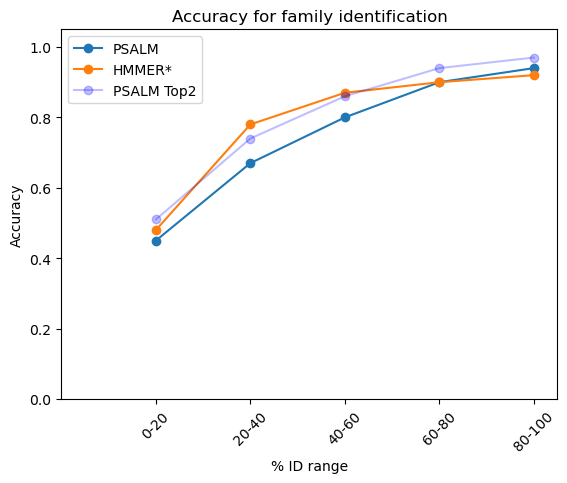

In [6]:
import matplotlib.pyplot as plt

fam_hmmer = [0.48,0.78,0.87,0.90,0.92]
fam_psalm2 = [0.51,0.74,0.86,0.94,0.97]
fam_psalm = [0.45, 0.67, 0.80, 0.90, 0.94]
pids = [0.2, 0.4, 0.6, 0.8, 1.0]

plt.figure()

plt.plot(pids, fam_psalm, label='PSALM', marker='o')

plt.plot(pids, fam_hmmer, label='HMMER*', marker='o')
plt.plot(pids, fam_psalm2, label='PSALM Top2', marker='o',alpha=0.25,c="blue")

plt.xlabel('% ID range')
plt.ylabel('Accuracy')
plt.xlim(0,1.05)
plt.xticks(pids, ['0-20', '20-40', '40-60', '60-80', '80-100'], rotation=45)
plt.ylim(0,1.05)
plt.legend()
plt.title('Accuracy for family identification')

Text(0.5, 1.0, 'Accuracy for family identification')

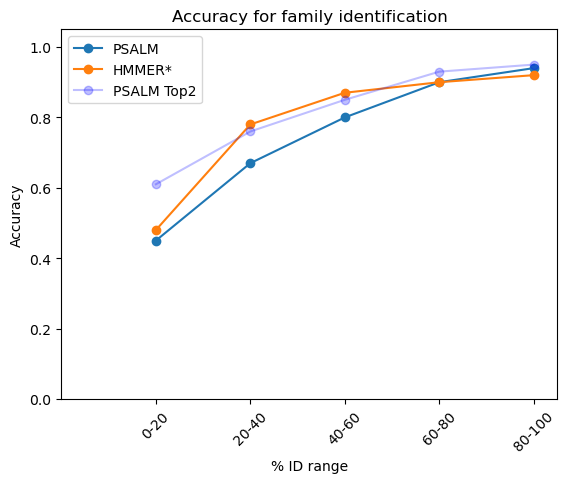

In [8]:
import matplotlib.pyplot as plt

fam_hmmer = [0.48,0.78,0.87,0.90,0.92]
fam_psalm2 = [0.61,0.76,0.85,0.93,0.95]
fam_psalm = [0.45, 0.67, 0.80, 0.90, 0.94]
pids = [0.2, 0.4, 0.6, 0.8, 1.0]

plt.figure()

plt.plot(pids, fam_psalm, label='PSALM', marker='o')

plt.plot(pids, fam_hmmer, label='HMMER*', marker='o')
plt.plot(pids, fam_psalm2, label='PSALM Top2', marker='o',alpha=0.25,c="blue")

plt.xlabel('% ID range')
plt.ylabel('Accuracy')
plt.xlim(0,1.05)
plt.xticks(pids, ['0-20', '20-40', '40-60', '60-80', '80-100'], rotation=45)
plt.ylim(0,1.05)
plt.legend()
plt.title('Accuracy for family identification')

In [16]:
import pickle

with open('../data/benchmarking/old_test_pids.pkl', 'rb') as f:
    pid_dict = pickle.load(f)
with open('../data/maps.pkl', 'rb') as f:
    maps = pickle.load(f)

In [19]:
result20 = [key for key,values in pid_dict if key in split_seqs[20] and "NC0001" in [maps["fam_clan"][x] for x in values.keys()]]

ValueError: too many values to unpack (expected 2)

In [22]:
def nc(pid):
    result_nc = []
    for seq in split_seqs[pid]:
        if "NC0001" in [maps["fam_clan"][x] for x in pid_dict[seq].keys()]:
            result_nc.append(seq)
    return(result_nc)

In [26]:
def not_nc(pid):
    result_nc = []
    for seq in split_seqs[pid]:
        if "NC0001" not in [maps["fam_clan"][x] for x in pid_dict[seq].keys()]:
            result_nc.append(seq)
    return(result_nc)

### Testing shuffled train seqs for shorter lengths

In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
import numpy as np
from string_utils import shuffle as sf

fl = '../data/train_fasta/train_ids_full.fasta'

with open('../data/train_fasta/shuffle_train.fasta', 'w') as ofile:

    ctr = 0
    lens = []

    for rec in SeqIO.parse(f'{fl}', 'fasta'):

        seq_len = len(str(rec.seq))

        if seq_len < 4096 and np.random.random() < 0.1:

            entry = rec
            entry.seq = Seq(sf(str(rec.seq)))
            entry.id = "Shuffled"
            SeqIO.write(entry, ofile, 'fasta')

            ctr += 1
            lens.append(seq_len)

ModuleNotFoundError: No module named 'string_utils'

(array([32182., 13646.,  4074.,  1118.,   459.,   265.,   126.,   113.,
           52.,    53.]),
 array([  15.,  422.,  829., 1236., 1643., 2050., 2457., 2864., 3271.,
        3678., 4085.]),
 <BarContainer object of 10 artists>)

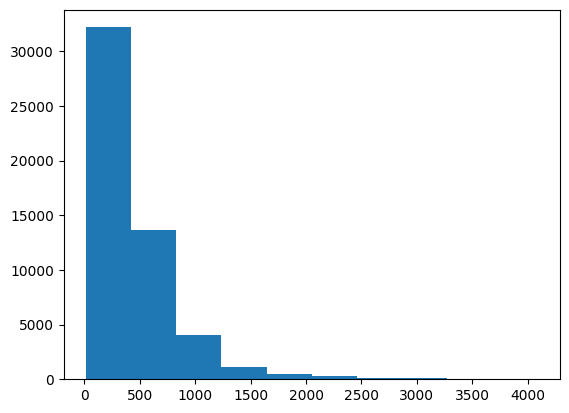

In [16]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()

ax.hist(lens, bins=10)

In [1]:
import pickle
import hmmscan_utils as hu

with open('../data/maps.pkl', 'rb') as f:
   maps = pickle.load(f)

for shard in range(1,51):

    print(f'Shard {shard}')

    results = {}

    hmm_dict = hu.parse_hmmscan_results(f'../data/test_scan_OLD/split_{shard}_test_ids_full.fasta_scan.txt')

    for label in hmm_dict.keys():
        fam_vector, clan_vector = hu.generate_domain_position_list2(hmm_dict, label, maps)
        
        fam_vector = np.argmax(fam_vector, axis=1)
        stop_index = min(fam_vector.shape[0], 4096)

        results[entry] = {}
        results[entry]['fam'] = fam_vector[:stop_index]
        results[entry]['clan'] = clan_vector[:stop_index]

    with open(f'../data/targets/test_OLD_shard_{shard}.pkl', 'wb') as f:
        pickle.dump(results, f)

In [2]:
import pickle

with open(f'../data/split_seqs.pkl' , 'rb') as f:
    split_seqs = pickle.load(f)
    
print(split_seqs[20])

['A0A010QQ35.1', 'A0A011Q2R1.1', 'A0A014M136.1', 'A0A014MCH3.1', 'A0A015IWS6.1', 'A0A015JZT5.1', 'A0A015K1J0.1', 'A0A015KGF6.1', 'A0A015KI96.1', 'A0A015L6N7.1', 'A0A015TUR2.1', 'A0A016TCX0.1', 'A0A016TDP1.1', 'A0A016TDP6.1', 'A0A016TDU5.1', 'A0A016TDX7.1', 'A0A016TDY1.1', 'A0A016U852.1', 'A0A016UQM8.1', 'A0A016URW7.1', 'A0A016USA0.1', 'A0A016UT87.1', 'A0A016UT93.1', 'A0A016WGW9.1', 'A0A016WZ94.1', 'A0A017H5W9.1', 'A0A022MH83.1', 'A0A022MKL9.1', 'A0A022MMF8.1', 'A0A023P495.1', 'A0A023Q224.1', 'A0A024FL68.1', 'A0A024HKA5.1', 'A0A024P254.1', 'A0A024QF81.1', 'A0A024TPS5.1', 'A0A026WX00.1', 'A0A026WYD3.1', 'A0A059AEF9.1', 'A0A059FEY5.1', 'A0A059FJ38.1', 'A0A059J8N6.1', 'A0A059MK51.1', 'A0A059NT63.1', 'A0A059W832.1', 'A0A059WKR5.1', 'A0A059WKY7.1', 'A0A060JGW2.1', 'A0A060LT58.1', 'A0A060LUQ6.1', 'A0A060S2X7.1', 'A0A060S9Y4.1', 'A0A060SSA2.1', 'A0A060T013.1', 'A0A061AFY5.1', 'A0A061NXL1.1', 'A0A061NXV8.1', 'A0A061PBU3.1', 'A0A061PDY5.1', 'A0A062TZM3.1', 'A0A062U4F6.1', 'A0A062XRH3.1', 'A0A063